## Setup

In [1]:
# Import statements
import xarray as xr
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
from metpy.plots import ctables
import numpy as np
from xskillscore import resample_iterations_idx
from dask.diagnostics.progress import ProgressBar
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.feature as cfeature
from typing import List
import matplotlib.patches as patches

plt.style.use("dark_background")
mpl.rcParams["hatch.linewidth"] = 0.2

In [2]:
# Define functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    """Overwrite 'ne' values in the DataArray or Dataset."""
    da["ne"] = range(5)
    return da


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def stack_and_chunk(data_arrays, dim_name, chunk_size):
    """Concatenate, stack, and chunk the given data arrays."""
    return (
        xr.concat(data_arrays, dim=dim_name)
        .stack(run=(dim_name, "ne"))
        .chunk({"run": chunk_size})
    )


def process_variable(
    wofs_list: List[xr.Dataset], var_name: str, overwrite: bool = False
) -> xr.DataArray:
    """Process a variable data with optional 'ne' overwrite."""
    data_arrays = [
        overwrite_ne(getattr(ds, var_name)) if overwrite else getattr(ds, var_name)
        for ds in wofs_list
    ]
    return stack_and_chunk(data_arrays, "init", "auto" if overwrite else -1)


def process_and_smooth(data, times, smooth_data=True, sigma=5):
    """Process and optionally smooth data for selected times."""
    selected_data = xr.concat([data.sel(time=time).squeeze() for time in times], dim='time').compute()
    if smooth_data:
        if isinstance(selected_data, xr.Dataset):
            # Apply smoothing to each variable in the Dataset
            smoothed_data = selected_data.map_blocks(lambda ds: ds.map(lambda x: smooth(x, sigma=sigma)))
            smoothed_data = smoothed_data.assign_attrs(data.attrs)
        elif isinstance(selected_data, xr.DataArray):
            smoothed_data = smooth(selected_data, sigma=sigma)
        return smoothed_data
    return selected_data



# Function to perform resampling and compute means
def resample_and_compute_means(
    data, time, lat_chunk=50, lon_chunk=50, iterations=1000, dim_max=20
):
    chunked_data = (
        data.sel(time=time).squeeze().chunk({"lat": lat_chunk, "lon": lon_chunk})
    )
    set1 = resample_iterations_idx(
        chunked_data, iterations, dim="run", replace=False, dim_max=dim_max
    ).mean(dim="run")
    set2 = resample_iterations_idx(
        chunked_data, iterations, dim="run", replace=False, dim_max=dim_max
    ).mean(dim="run")
    return set1, set2


# Function to compute differences and quantiles
def compute_difference_and_quantiles(set1, set2):
    return (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()


def calc_theta(T: xr.DataArray, p: int) -> xr.DataArray:
    """Calculate potential temperature in Kelvin."""
    return (T + 273.15) * ((1000 / p) ** 0.286)


# Compute masks
def compute_mask(diff, results):
    return (diff < results.sel(quantile=0.05).squeeze()) | (
        diff > results.sel(quantile=0.95).squeeze()
    )


def process_theta(wofs_list, level, overwrite=False):
    """Process temperature data and calculate potential temperature."""
    temp_var = f"temperature_{level}"
    theta = process_variable(wofs_list, temp_var, overwrite)
    return calc_theta(theta, level)


def process_winds(wofs_list, level, overwrite=False):
    """Process wind data and merge U and V components."""
    u_var = f"U_{level}"
    v_var = f"V_{level}"
    u_data = process_variable(wofs_list, u_var, overwrite)
    v_data = process_variable(wofs_list, v_var, overwrite)
    return xr.merge([u_data, v_data])


def set_lat_lon(dataarrays, step=3000, size=900000):
    """Set lat/lon values."""
    for da in dataarrays:
        da["lat"] = range(0, size, step)
        da["lon"] = range(0, size, step)


def calculate_gradient(theta):
    """Calculate gradients along x and y."""
    grad_x = theta.differentiate("lon")
    grad_y = theta.differentiate("lat")
    return grad_x, grad_y


def calculate_advection(uv, grad_x, grad_y):
    """Calculate temperature advection."""
    level = uv.attrs["level"].lstrip("P")  # Remove 'P' prefix
    u = uv[f"U_{level}"]  # .chunk(grad_x.chunks)
    v = uv[f"V_{level}"]  # .chunk(grad_y.chunks)
    return (u * grad_x) + (v * grad_y)

def calculate_frontogenesis(
    theta: xr.DataArray, u: xr.DataArray, v: xr.DataArray
) -> xr.DataArray:
    """Calculate frontogenesis using the provided formula.

    Parameters:
    - theta: Potential temperature (xarray.DataArray)
    - u: Zonal wind component (xarray.DataArray)
    - v: Meridional wind component (xarray.DataArray)

    Returns:
    - frontogenesis: Frontogenesis (xarray.DataArray)
    """
    # Calculate temperature gradients
    theta_x = theta.differentiate("lon")
    theta_y = theta.differentiate("lat")
    mag_grad_theta = np.sqrt(theta_x**2 + theta_y**2)

    # Calculate wind component gradients
    u_x = u.differentiate("lon")
    u_y = u.differentiate("lat")
    v_x = v.differentiate("lon")
    v_y = v.differentiate("lat")

    # Avoid division by zero by setting a small epsilon where mag_grad_theta is zero
    epsilon = 1e-10
    mag_grad_theta = xr.where(mag_grad_theta == 0, epsilon, mag_grad_theta)

    # Calculate each component of the frontogenesis formula
    term1 = -theta_x * (u_x * theta_x + v_x * theta_y)
    term2 = -theta_y * (u_y * theta_x + v_y * theta_y)

    # Sum the terms and divide by the magnitude of the temperature gradient
    frontogenesis = (term1 + term2) / mag_grad_theta
    frontogenesis.attrs = theta.attrs  # Preserve attributes
    frontogenesis.name = "frontogenesis"

    return frontogenesis

In [3]:
# Read in WoFS initializations 20–23Z
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Get MetPy colortables
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

## Create wet & dry ensembles

In [5]:
# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Sort by Central Park precipitation
rain_nyc_0102 = [
    w.rain.isel(lat=lat_ind, lon=lon_ind)
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .squeeze()
    for w in wofs_all
]

# Get indices of wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne") for r in rain_nyc_0102
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne") for r in rain_nyc_0102
]

# Select wet and dry members
wofs_wet = [w.sel(ne=ne_wet[i].astype(int)) for i, w in enumerate(wofs_all)]
wofs_dry = [w.sel(ne=ne_dry[i].astype(int)) for i, w in enumerate(wofs_all)]

## Calculate Frontogenesis

### Read in variables

In [7]:
# Define times of interest
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00"]

def process_and_select_theta(wofs_list, level, times, overwrite=False):
    """Process and select temperature data for specific times."""
    theta = process_theta(wofs_list, level, overwrite)
    # Select the desired times using xr.concat and list comprehension
    selected_theta = xr.concat([theta.sel(time=time) for time in times], dim="time")
    return selected_theta

theta850_all = process_and_select_theta(wofs_all, 850, times)
theta850_wet = process_and_select_theta(wofs_wet, 850, times, overwrite=True)
theta850_dry = process_and_select_theta(wofs_dry, 850, times, overwrite=True)

theta700_all = process_and_select_theta(wofs_all, 700, times)
theta700_wet = process_and_select_theta(wofs_wet, 700, times, overwrite=True)
theta700_dry = process_and_select_theta(wofs_dry, 700, times, overwrite=True)

# Process wind data
uv700_all = process_winds(wofs_all, 700)
uv700_wet = process_winds(wofs_wet, 700, overwrite=True)
uv700_dry = process_winds(wofs_dry, 700, overwrite=True)

uv850_all = process_winds(wofs_all, 850)
uv850_wet = process_winds(wofs_wet, 850, overwrite=True)
uv850_dry = process_winds(wofs_dry, 850, overwrite=True)

# Set lat/lon values
set_lat_lon(
    [
        theta850_all,
        theta850_wet,
        theta850_dry,
        theta700_all,
        theta700_wet,
        theta700_dry,
        uv850_all,
        uv850_wet,
        uv850_dry,
        uv700_all,
        uv700_wet,
        uv700_dry,
    ]
)

# Smooth the data
with ProgressBar():
    theta850_all = process_and_smooth(theta850_all, times, smooth_data=True, sigma=5)
    theta850_wet = process_and_smooth(theta850_wet, times, smooth_data=True, sigma=5)
    theta850_dry = process_and_smooth(theta850_dry, times, smooth_data=True, sigma=5)

    theta700_all = process_and_smooth(theta700_all, times, smooth_data=True, sigma=5)
    theta700_wet = process_and_smooth(theta700_wet, times, smooth_data=True, sigma=5)
    theta700_dry = process_and_smooth(theta700_dry, times, smooth_data=True, sigma=5)

    uv700_all = process_and_smooth(uv700_all, times, smooth_data=True, sigma=5)
    uv700_wet = process_and_smooth(uv700_wet, times, smooth_data=True, sigma=5)
    uv700_dry = process_and_smooth(uv700_dry, times, smooth_data=True, sigma=5)

    uv850_all = process_and_smooth(uv850_all, times, smooth_data=True, sigma=5)
    uv850_wet = process_and_smooth(uv850_wet, times, smooth_data=True, sigma=5)
    uv850_dry = process_and_smooth(uv850_dry, times, smooth_data=True, sigma=5)

[########################################] | 100% Completed | 1.22 sms
[########################################] | 100% Completed | 720.19 ms
[########################################] | 100% Completed | 513.11 ms
[########################################] | 100% Completed | 712.54 ms
[########################################] | 100% Completed | 416.78 ms
[########################################] | 100% Completed | 418.50 ms
[########################################] | 100% Completed | 1.22 sms
[########################################] | 100% Completed | 414.53 ms
[########################################] | 100% Completed | 416.94 ms
[########################################] | 100% Completed | 1.22 sms
[########################################] | 100% Completed | 416.97 ms
[########################################] | 100% Completed | 417.17 ms


In [27]:
wofs_all[0]

<xarray.Dataset> Size: 97GB
Dimensions:               (time: 73, ne: 18, lat: 300, lon: 300, NY: 300,
                           NX: 300, dim_0: 20, dim_1: 20, nz: 50, nx: 20, ny: 20)
Coordinates:
  * time                  (time) object 584B 2021-09-01 20:00:00 ... 2021-09-...
Dimensions without coordinates: ne, lat, lon, NY, NX, dim_0, dim_1, nz, nx, ny
Data variables: (12/114)
    10-500m_bulkshear     (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    QVAPOR_500            (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    QVAPOR_700            (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    QVAPOR_850            (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    U_500                 (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    U_700                 (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    ...                    ...
    wz_0to2_instant       (time, ne, lat, lon) float64 946MB dask.array<chunksize=(1, 18, 300, 300), meta=np.ndarray>
    xlat                  (time, NY, NX) float32 26MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    xlat_snd              (time, dim_0, dim_1) float32 117kB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    xlon                  (time, NY, NX) float32 26MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    xlon_snd              (time, dim_0, dim_1) float32 117kB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    z_agl                 (time, ne, nz, nx, ny) float64 210MB dask.array<chunksize=(1, 18, 50, 20, 20), meta=np.ndarray>
Attributes: (12/98)
    TITLE:                            OUTPUT FROM WRF V3.9pre#2 MODEL
    START_DATE:                      2021-09-01_20:00:00
    WEST-EAST_GRID_DIMENSION:        301
    SOUTH-NORTH_GRID_DIMENSION:      301
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3000.0
    ...                              ...
    lon_pin:                         -80.55682
    lat_pin:                         36.372017
    init_time:                       20210901_200000
    valid_time:                      20210901_200000
    history:                         Mon Nov  6 22:10:28 2023: ncks --ovr -4 ...
    NCO:                             netCDF Operators version 5.0.4 (Homepage...

In [8]:
# Calculate frontogenesis

front850_all = calculate_frontogenesis(theta850_all, uv850_all.U_850, uv850_all.V_850)
front850_wet = calculate_frontogenesis(theta850_wet, uv850_wet.U_850, uv850_wet.V_850)
front850_dry = calculate_frontogenesis(theta850_dry, uv850_dry.U_850, uv850_dry.V_850)

front700_all = calculate_frontogenesis(theta700_all, uv700_all.U_700, uv700_all.V_700)
front700_wet = calculate_frontogenesis(theta700_wet, uv700_wet.U_700, uv700_wet.V_700)
front700_dry = calculate_frontogenesis(theta700_dry, uv700_dry.U_700, uv700_dry.V_700)

In [9]:
results_850, results_700 = [], []

# Use Dask for parallel processing
with ProgressBar():
    for time in times:
        front850_set1, front850_set2 = resample_and_compute_means(front850_all, time)
        front700_set1, front700_set2 = resample_and_compute_means(front700_all, time)

        results_850.append(dask.delayed(compute_difference_and_quantiles)(front850_set1, front850_set2))
        results_700.append(dask.delayed(compute_difference_and_quantiles)(front700_set1, front700_set2))

    # Compute all results in parallel
    results_850 = dask.compute(*results_850)
    results_700 = dask.compute(*results_700)

# Combine results along the new time dimension
results_850 = xr.concat(results_850, dim="time")
results_700 = xr.concat(results_700, dim="time")

# Take ensemble means of wet and dry front
front850_wet,front850_dry = front850_wet.mean(dim="run"), front850_dry.mean(dim="run")
front700_wet,front700_dry = front700_wet.mean(dim="run"), front700_dry.mean(dim="run")

# Compute differences
front850_diff = front850_wet - front850_dry
front700_diff = front700_wet - front700_dry

front850_mask = compute_mask(front850_diff, results_850)
front700_mask = compute_mask(front700_diff, results_700)

[########################################] | 100% Completed | 50.82 ss
[########################################] | 100% Completed | 50.13 ss


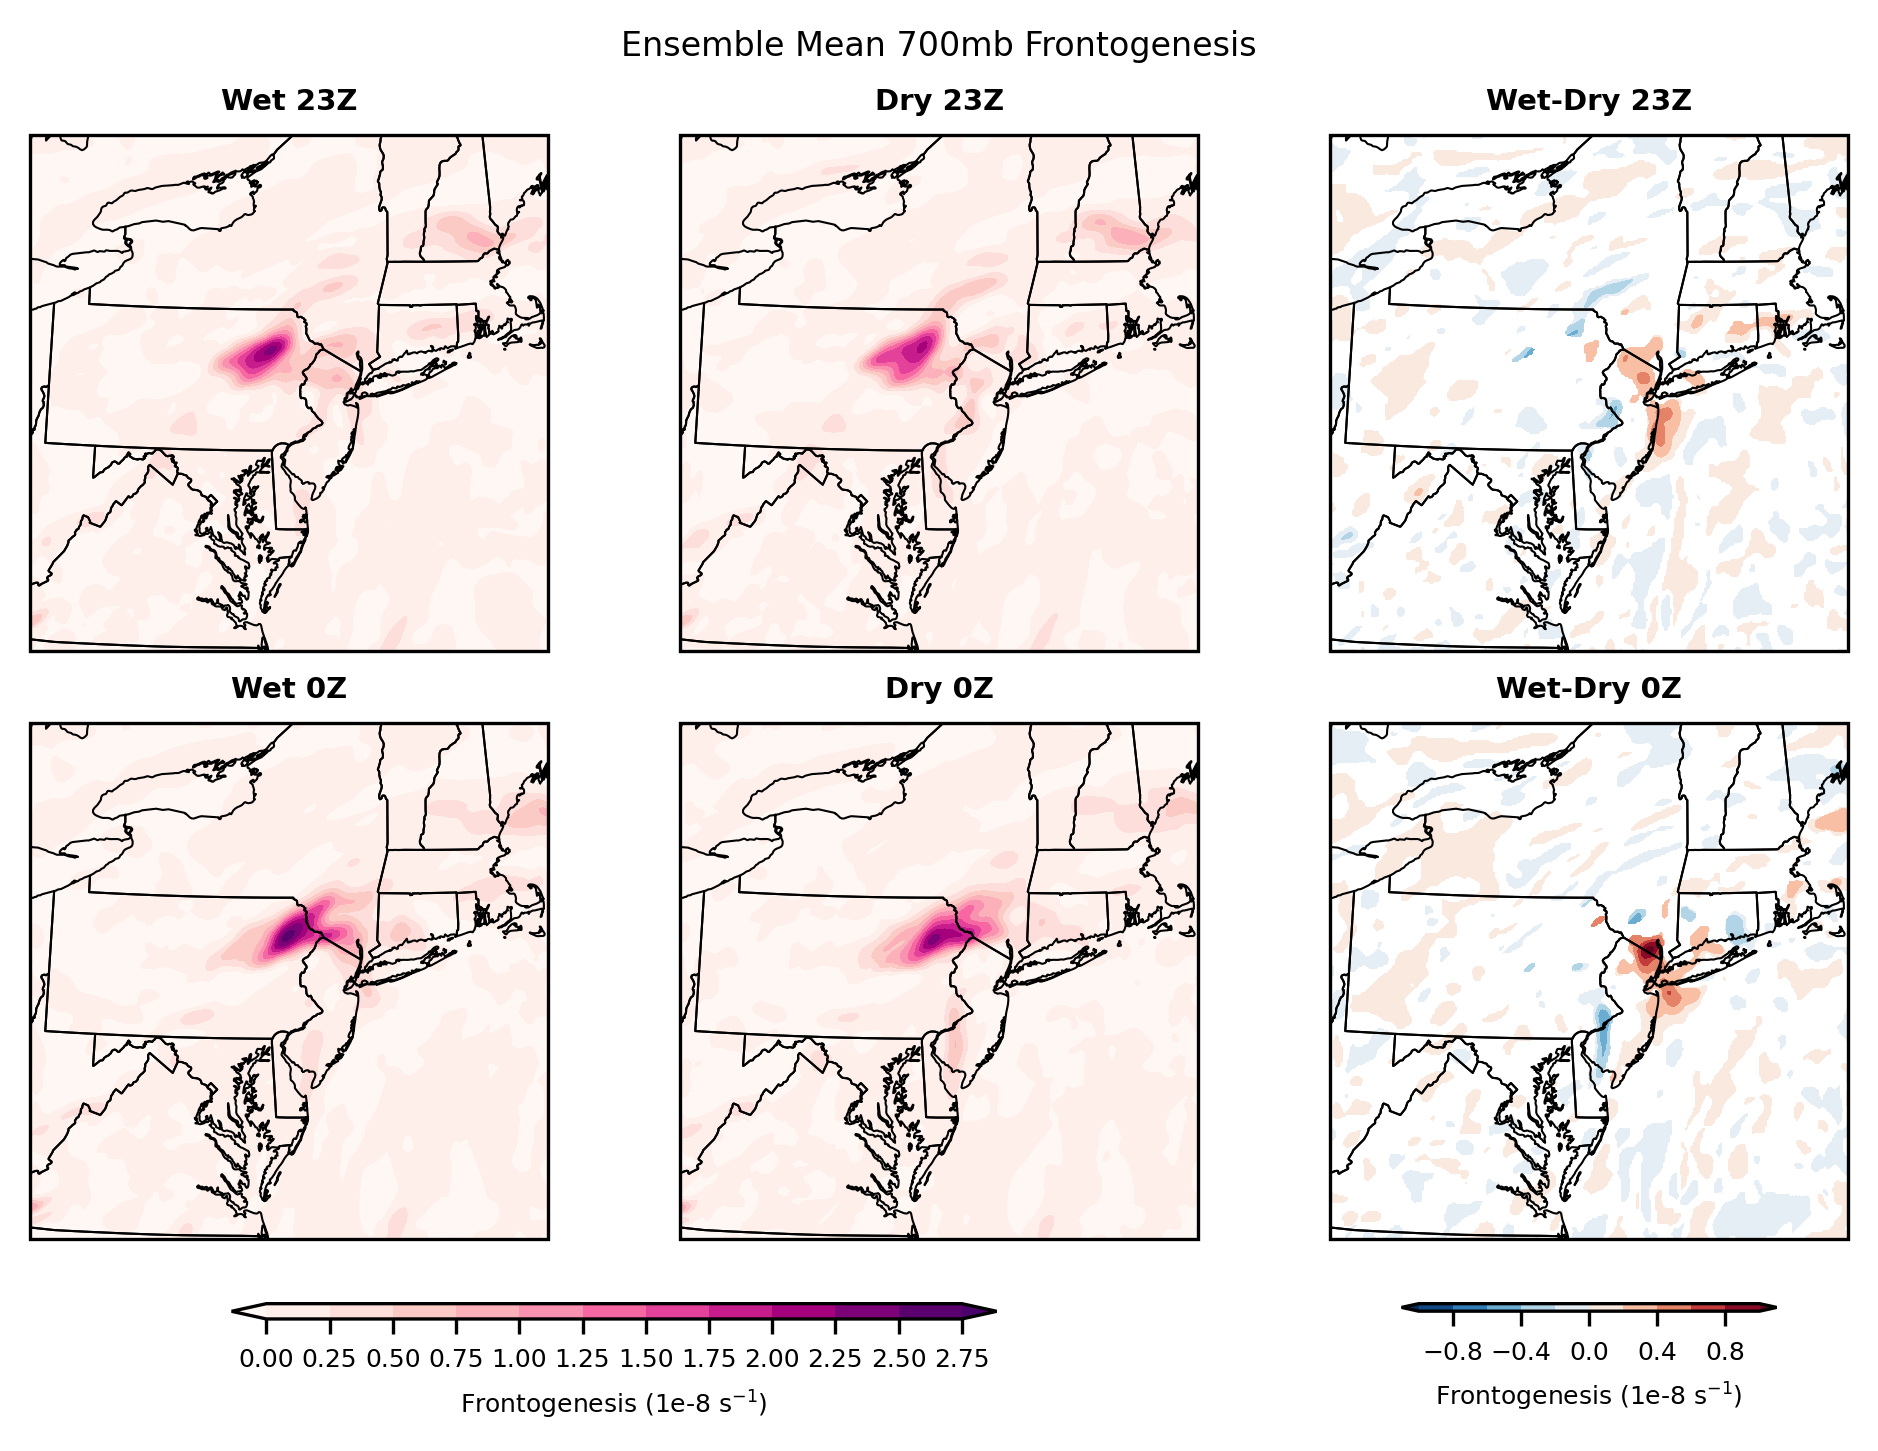

In [23]:
plt.style.use("default")

# Titles
titles = ["Wet 23Z", "Dry 23Z", "Wet-Dry 23Z", "Wet 0Z", "Dry 0Z", "Wet-Dry 0Z"]

fronts = [
    data.isel(time=t).squeeze()
    for t in range(2)
    for data in [front700_wet, front700_dry, front700_diff]
]
masks = [front700_mask.isel(time=t) for t in range(2)]

fig, axes = plt.subplots(
    2,
    3,
    figsize=(6.5, 4.7),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

cf_objs = []

for i, ax in enumerate(axes.flat):  # type: ignore
    if i not in [2, 5]:
        cmap = "RdPu"
        levs = np.arange(0, 2.76, 0.25)
        mask = np.ones(fronts[i].values.shape)
    else:
        cmap = "RdBu_r"
        mask = masks[i % 2]
        levs = np.arange(-1, 1.1, 0.2)

    cf = ax.contourf(
        lon,
        lat,
        fronts[i].where(mask).values * 1e8,
        transform=ccrs.PlateCarree(),
        levels=levs,
        cmap=cmap,
        extend="both",
    )
    cf_objs.append(cf)

    # add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    # Add title
    ax.set_title(titles[i], fontsize=7, fontweight="bold")

# Add shared colorbars
cbar1 = fig.colorbar(
    cf_objs[0],
    ax=axes[:, :2],
    shrink=0.6,
    aspect=50,
    orientation="horizontal",
    extend="both",
)
cbar1.ax.tick_params(labelsize=6)
cbar1.set_label(r"Frontogenesis (1e-8 s$^{-1}$)", fontsize=6)
cbar1.set_ticks(np.arange(0, 2.76, 0.25))

# Add separate colorbar for the last column
cbar2 = fig.colorbar(
    cf_objs[2],
    ax=axes[:, 2],
    shrink=0.6,
    aspect=50,
    orientation="horizontal",
    extend="both",
)
cbar2.ax.tick_params(labelsize=6)
cbar2.set_label(r"Frontogenesis (1e-8 s$^{-1}$)", fontsize=6)

# Set suptitle
plt.suptitle("Ensemble Mean 700mb Frontogenesis", fontsize=8)

plt.show()

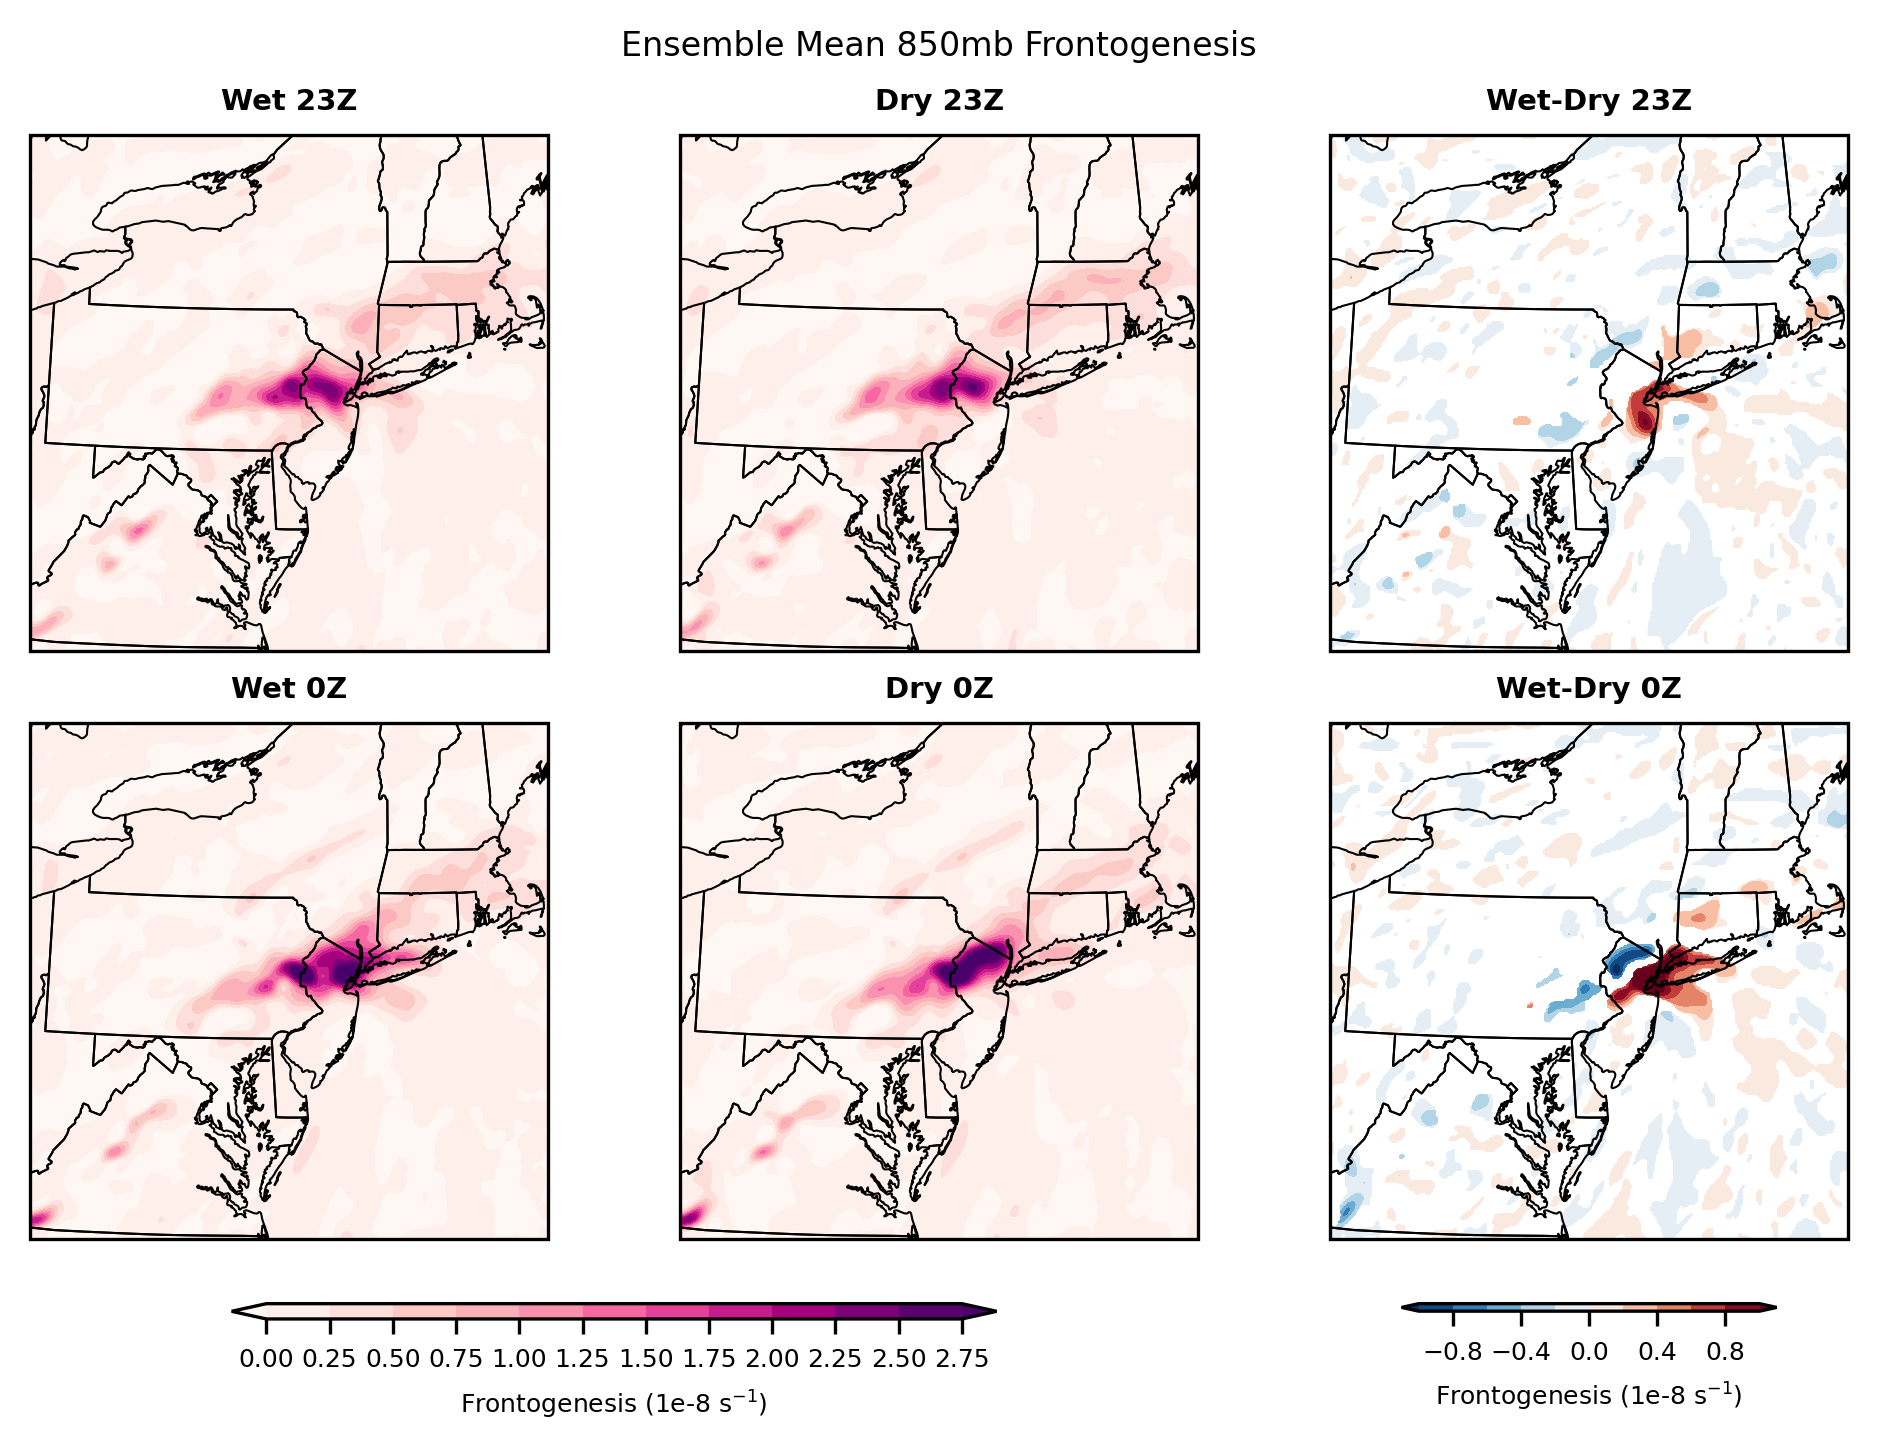

In [26]:
plt.style.use("default")

# Titles
titles = ["Wet 23Z", "Dry 23Z", "Wet-Dry 23Z", "Wet 0Z", "Dry 0Z", "Wet-Dry 0Z"]

fronts = [
    data.isel(time=t).squeeze()
    for t in range(2)
    for data in [front850_wet, front850_dry, front850_diff]
]
masks = [front850_mask.isel(time=t) for t in range(2)]

fig, axes = plt.subplots(
    2,
    3,
    figsize=(6.5, 4.7),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

cf_objs = []

for i, ax in enumerate(axes.flat):  # type: ignore
    if i not in [2, 5]:
        cmap = "RdPu"
        levs = np.arange(0, 2.76, 0.25)
        mask = np.ones(fronts[i].values.shape)
    else:
        cmap = "RdBu_r"
        mask = masks[i % 2]
        levs = np.arange(-1, 1.1, 0.2)

    cf = ax.contourf(
        lon,
        lat,
        fronts[i].where(mask).values * 1e8,
        transform=ccrs.PlateCarree(),
        levels=levs,
        cmap=cmap,
        extend="both",
    )
    cf_objs.append(cf)

    # add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    # Add title
    ax.set_title(titles[i], fontsize=7, fontweight="bold")

# Add shared colorbars
cbar1 = fig.colorbar(
    cf_objs[0],
    ax=axes[:, :2],
    shrink=0.6,
    aspect=50,
    orientation="horizontal",
    extend="both",
)
cbar1.ax.tick_params(labelsize=6)
cbar1.set_label(r"Frontogenesis (1e-8 s$^{-1}$)", fontsize=6)
cbar1.set_ticks(np.arange(0, 2.76, 0.25))

# Add separate colorbar for the last column
cbar2 = fig.colorbar(
    cf_objs[2],
    ax=axes[:, 2],
    shrink=0.6,
    aspect=50,
    orientation="horizontal",
    extend="both",
)
cbar2.ax.tick_params(labelsize=6)
cbar2.set_label(r"Frontogenesis (1e-8 s$^{-1}$)", fontsize=6)

# Set suptitle
plt.suptitle("Ensemble Mean 850mb Frontogenesis", fontsize=8)

plt.show()